#### Usage: 

1. To run the BO-DBA attck:
   In order to check the efficiency of the BO-DBA attac with different models, please use any    of these model names -> perlin, gabor, BICU, BILI, CLUSTER, NN, in place of the blank        space given in this (noiseGenerator = '       ') in cell number 5.
   
2. To run the HJSA attack:
   In order to check the efficiency of the BO-DBA attac with different models, please use any    of these model names -> norm,l2,linf,in place of the blank space given in this (constraint    = '    ') in cell number 6.


In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2022-03-02 16:49:42.168568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-02 16:49:42.216492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 16:49:42.216829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.755GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-02 16:49:42.216865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 16:49:42.217197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import random
from  keras.preprocessing.image import save_img

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
import yaml
from Util import *
from IPython import display
import copy
%matplotlib inline

Using TensorFlow backend.
2022-03-02 16:49:46.521011: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-02 16:49:46.542371: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2022-03-02 16:49:46.542816: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563282edde30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-02 16:49:46.542842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-02 16:49:46.670121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 16:49:46.670478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusI

In [3]:
#Global configuration
attackMode = 'Raw' #Raw: means without defense, Detection: With adversarial exmaples detection, Target means targeted attack
queryBudgets = 500 #Query Budgets
random.seed(42) #Set random seeds

2022-03-02 16:49:59.393267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-02 16:49:59.537959: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-02 16:50:00.214360: W tensorflow/stream_executor/gpu/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


bath_towel: 0.9135851
diaper: 0.0036552846
bib: 0.0028010367
bassinet: 0.0018440059
pelican: 0.0011003048
shower_cap: 0.0010816306


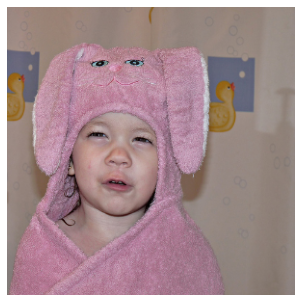

In [4]:
#Select random target image
oriImg= randomimg(mode = attackMode,target=0)
display_images(oriImg.img)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 299, 299, 3)
Attack result: L2:8.396797180175781, Linf:0.023039251565933228


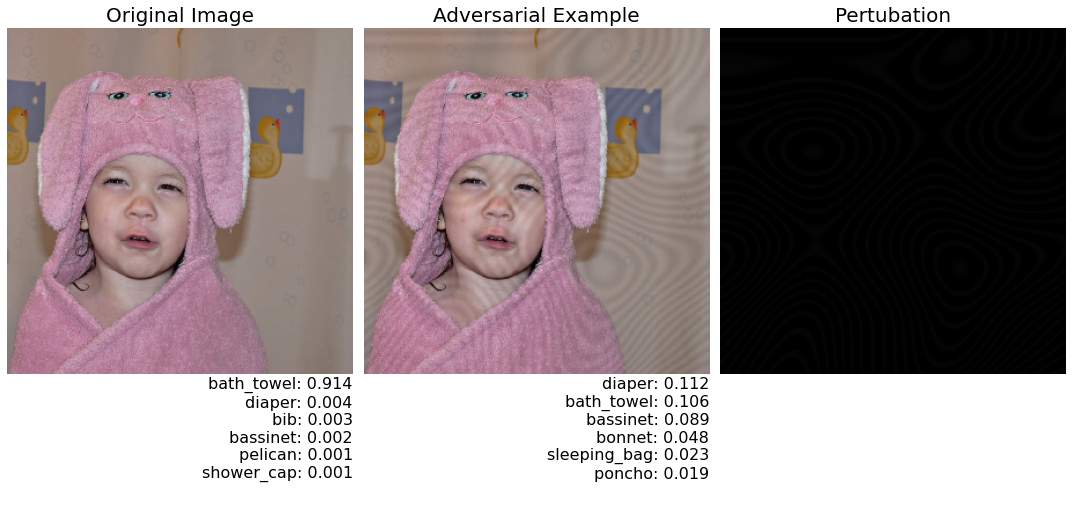

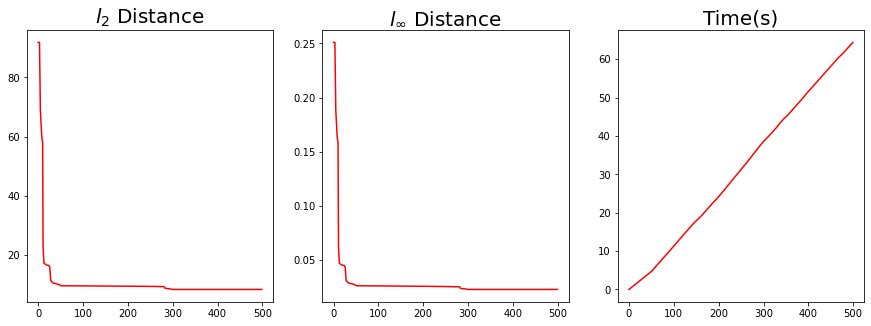

In [10]:
#BO-DBA attack
from BODBA import bayesian_attack
noiseGenerator = 'perlin'#Options: perlin; gabor; BICU; BILI; CLUSTER; NN
constraint = 'linf'#norm: l2; linf
oriImg_copy = copy.deepcopy(oriImg)
with tf.device('/GPU:0'): 
        timehistory,adversarial = bayesian_attack(oriImg_copy,max_query=queryBudgets,
                                                             noise=noiseGenerator,constraint=constraint,init_query=5)
print(adversarial.shape)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:48.50902557373047, Linf:0.3618224859237671


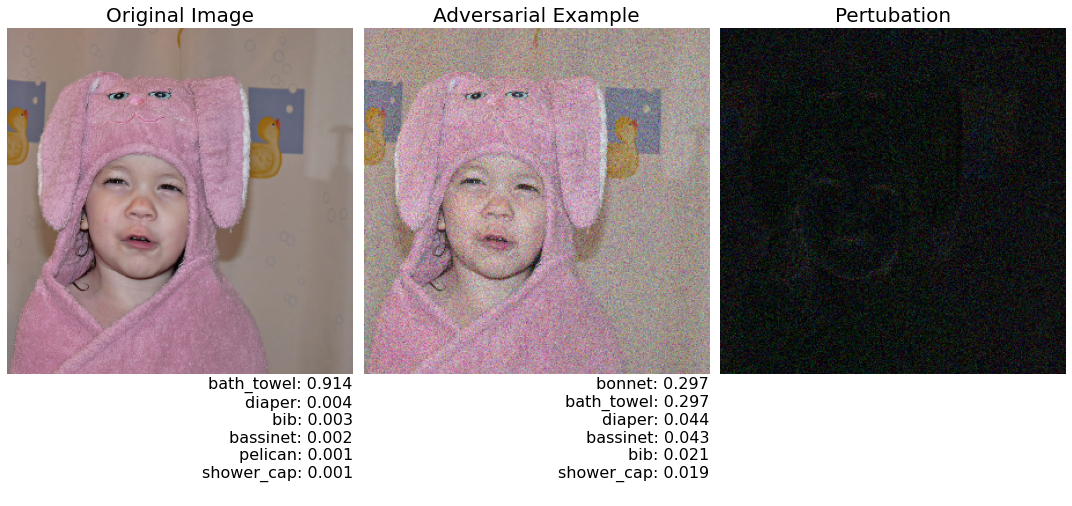

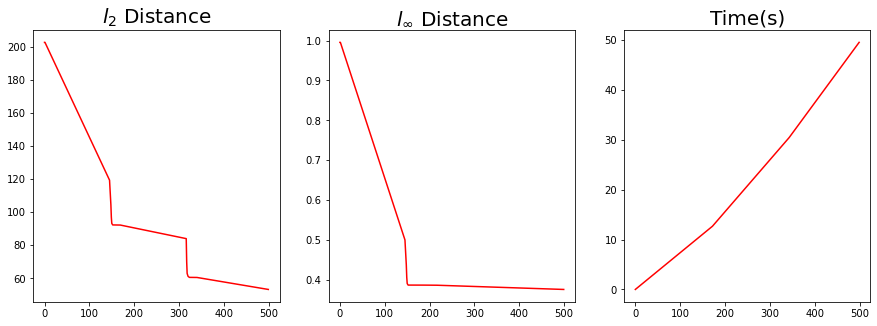

In [12]:
#HJSA attack
from HJSA import hsja
constraint = 'l2'#norm: l2; linf
oriImg_copy = copy.deepcopy(oriImg)
with tf.device('/GPU:0'): 
        timehistory,adversarial = hsja(oriImg_copy,constraint=constraint,
                                                  max_query=queryBudgets,verbose=False)
if adversarial is None:
    print('Initialisation failed')
else:
    print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
    History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
    DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:3.37982177734375, Linf:0.061131954193115234


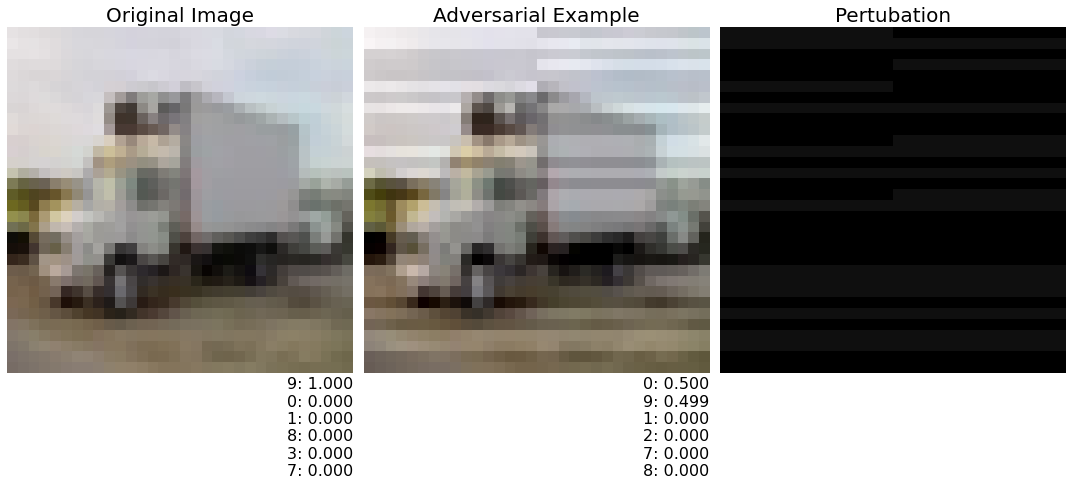

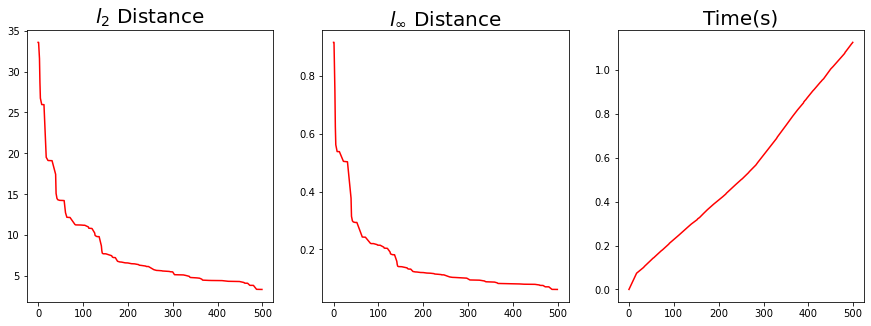

In [9]:
#RayS attack
from RayS import RayS
oriImg_copy = copy.deepcopy(oriImg)
attack = RayS(oriImg_copy,order=np.inf, epsilon=0.3, early_stopping=False)
with tf.device('/GPU:0'):
    timehistory,adversarial=attack.attack_hard_label(query_limit=queryBudgets)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

Searching for the initial direction on 100 random directions: 
--------> Found distortion 5.2257
--------> Found distortion 3.9710
--------> Found distortion 3.4242
--------> Found distortion 3.3464
--------> Found distortion 3.1250
--------> Found distortion 3.0129
==========> Found best distortion 3.0129 in 0.4480 seconds using 271 queries: 276


  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:2.1957621683188155, Linf:0.15873209634374535


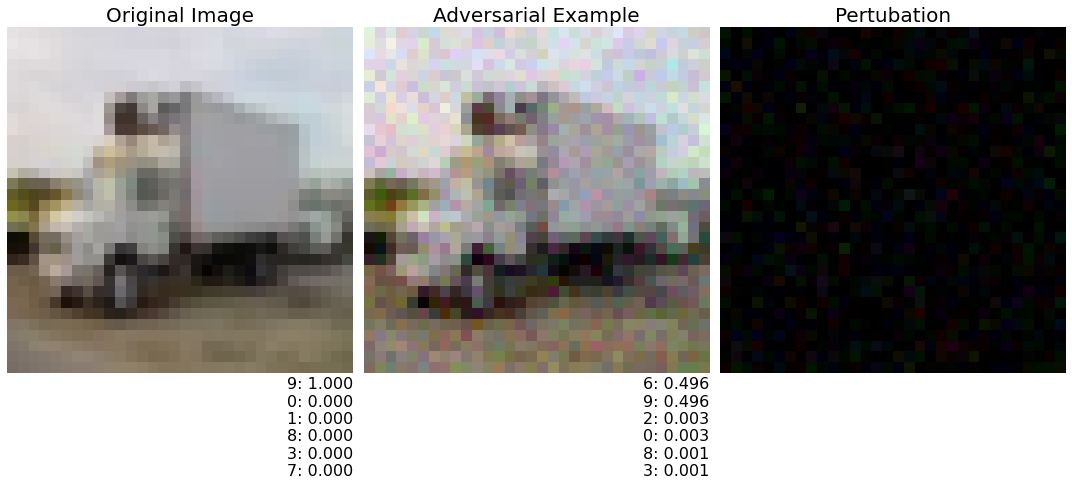

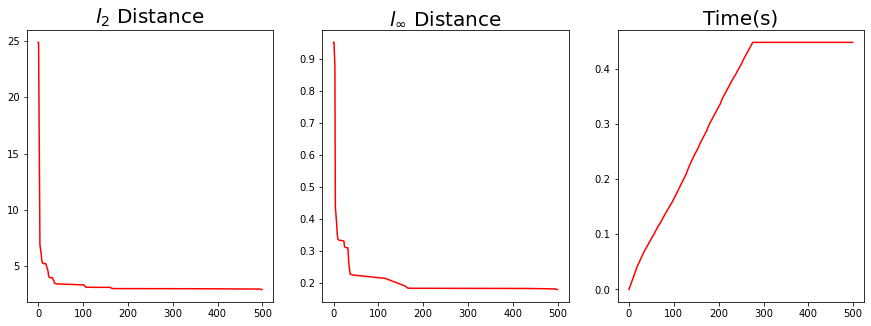

In [10]:
#SignOPT attack
from SignOPT import OPT_attack_sign_SGD
oriImg_copy = copy.deepcopy(oriImg)
attack = OPT_attack_sign_SGD(oriImg_copy)
with tf.device('/GPU:0'):
    timehistory,adversarial=attack.attack_untargeted(query_limit=queryBudgets)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)